## Calculate AOU

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import xarray as xr
import os
import cftime
import gsw

In [ ]:
# I/O setup
dir_in = '/Users/nd20983/Documents/data/'
data_list = ['xpvha','xpvhb','xpvhc','xpvhr','xpvhw',]
dscb_list = ['GETECH','Scotese','Robertsons','GET_RC','GET_LC']
file_tail = 'o.pfclann.nc'
dir_out = os.path.abspath(os.path.join(
    os.getcwd(), '..','..','Simulations','data','OBM','figures'))
os.makedirs(dir_out, exist_ok=True)
# dir_outpath = os.path.join(dir_out, f"aour_map_{i}.png")

# read in files
ds_list = []
for data in data_list:
    filename = os.path.join(dir_in, data + file_tail)
    # non-standard time units
    ds = xr.open_dataset(filename, decode_times=False)
    # manually convert time to cftime
    ds['t'].attrs['units'] = 'days since 2850-12-01 00:00:00'
    ds = xr.decode_cf(ds)
    ds_list.append(ds)

# loop over ds_list
for i, ds in enumerate(ds_list):
    # get essential variables
    temp = ds['temp_mm_dpth']
    salt = ds['salinity_mm_dpth']
    oxygen = ds['O2_mm_dpth']
    # get coordinates
    lat = ds['latitude']
    lon = ds['longitude']
    depth = ds['depth_2']

    # compute oxygen solubility (in umol/kg)
    O2_sat = gsw.O2sol_SP_pt(salt.values, temp.values)

    # compute AOU
    aou = xr.DataArray(O2_sat - oxygen.values, coords=oxygen.coords, dims=oxygen.dims)
    aou.name = 'AOU'
    aou.attrs["units"] = "µmol/kg"
    aou.attrs["long_name"] = "Apparent Oxygen Utilization"

    # add to dataset
    ds['AOU'] = aou


/var/folders/sq/wfj9lzcx6437thzlt85cgjwr0000gp/T/ipykernel_45977/39384987.py:19: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.decode_cf(ds)
/var/folders/sq/wfj9lzcx6437thzlt85cgjwr0000gp/T/ipykernel_45977/39384987.py:19: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.decode_cf(ds)
/var/folders/sq/wfj9lzcx6437thzlt85cgjwr0000gp/T/ipykernel_45977/39384987.py:19: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning us

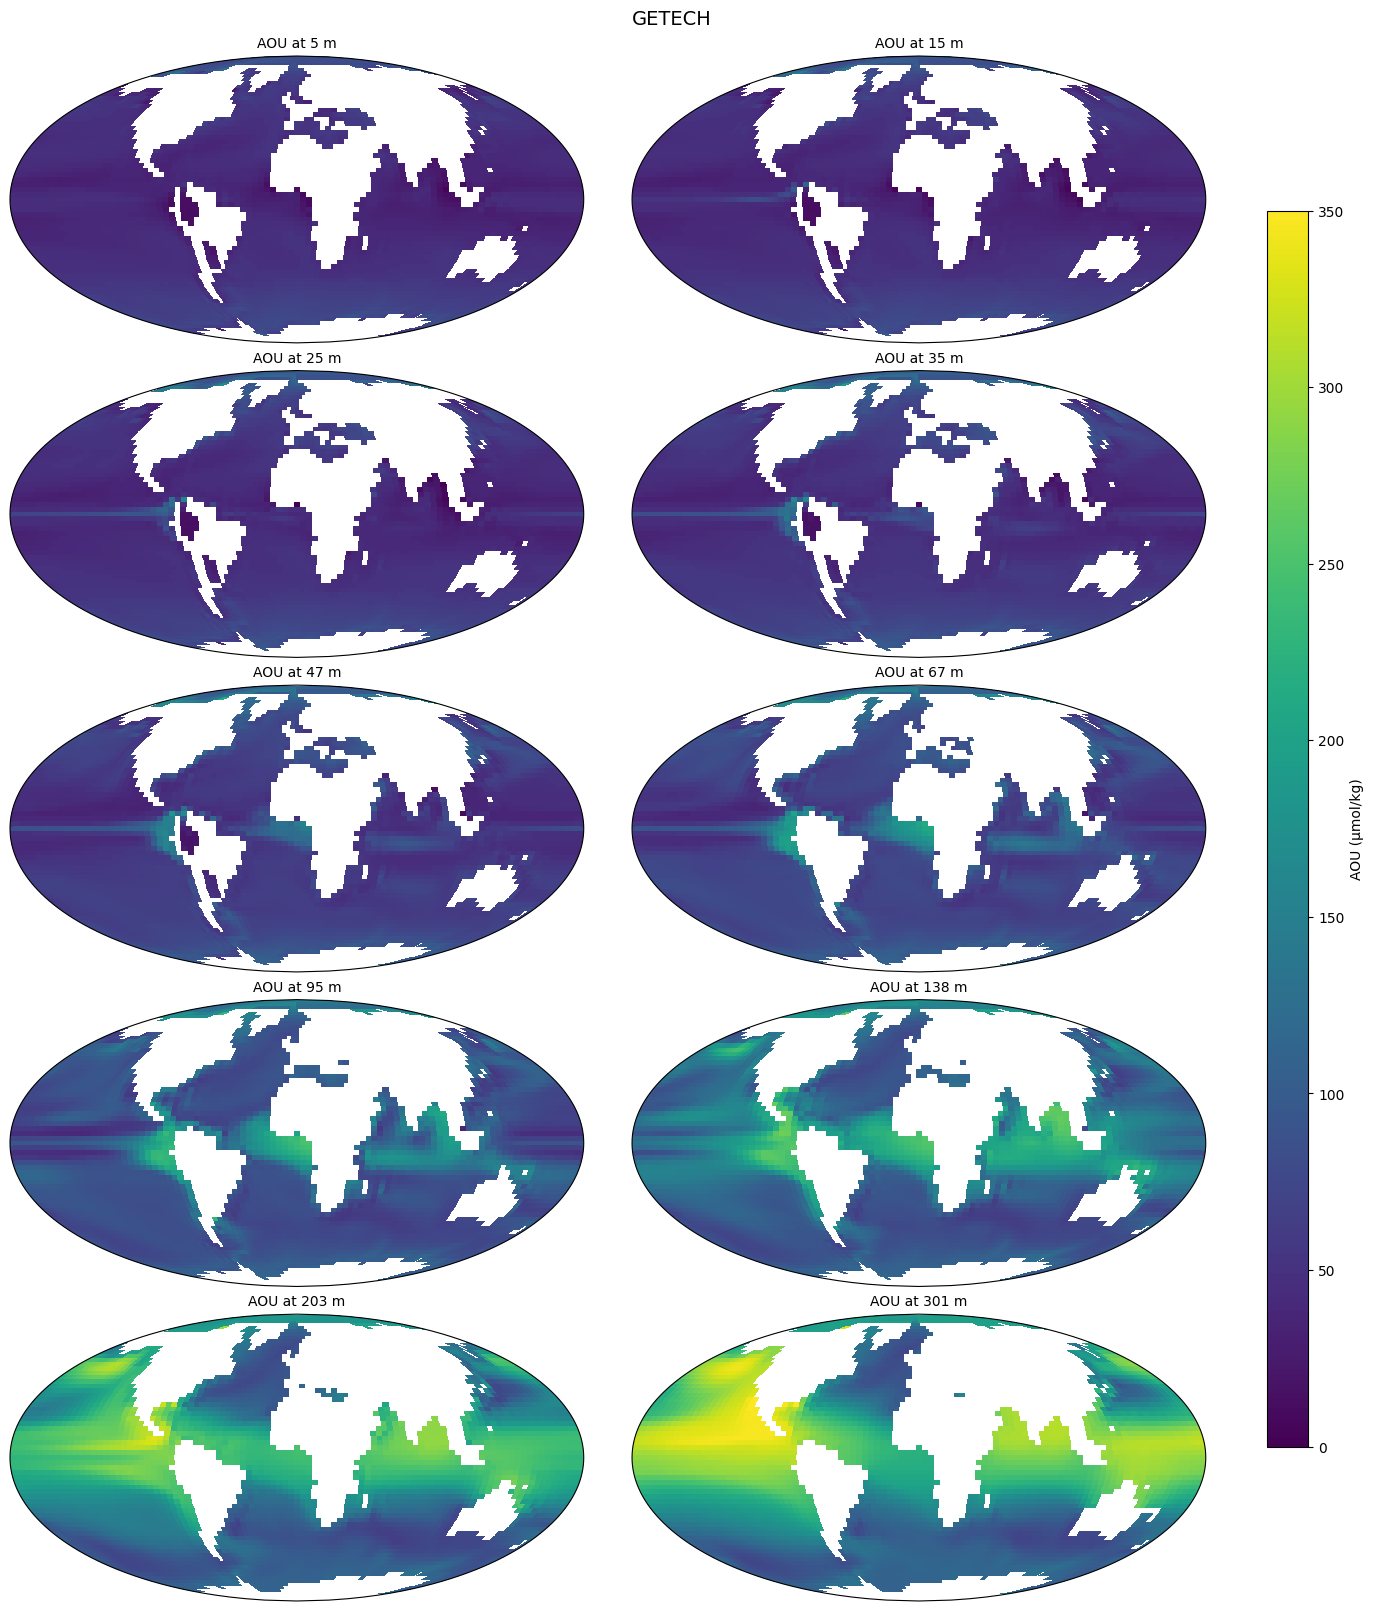

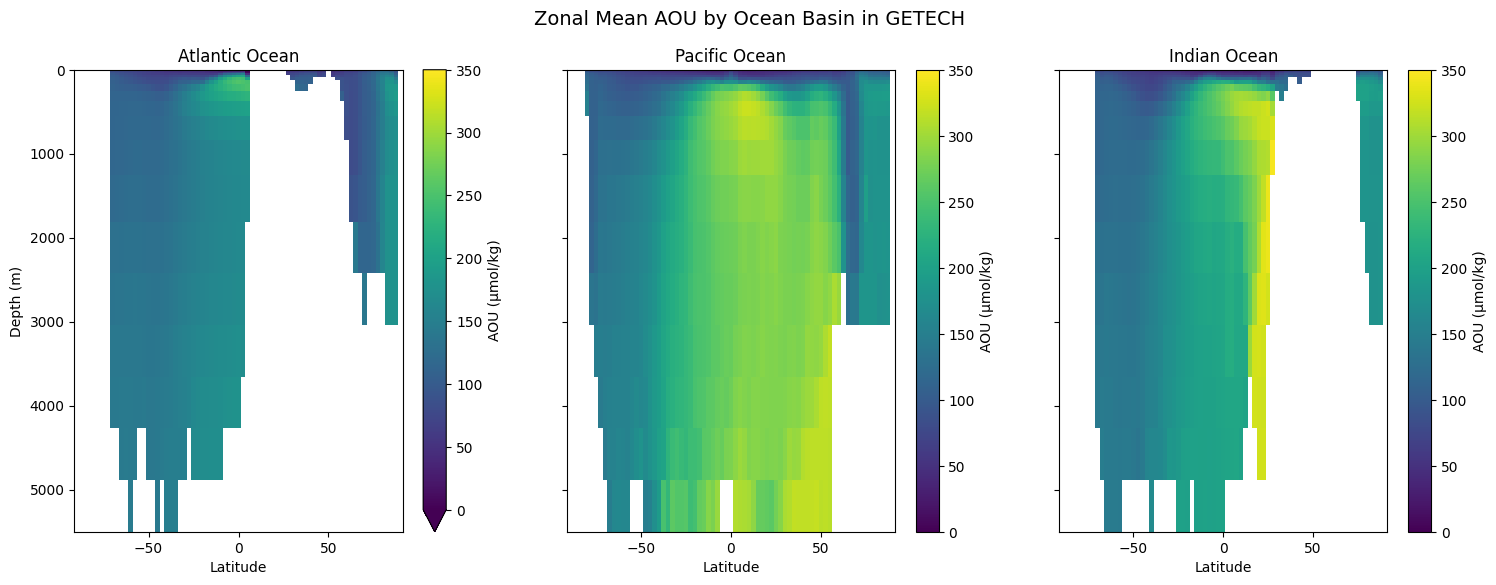

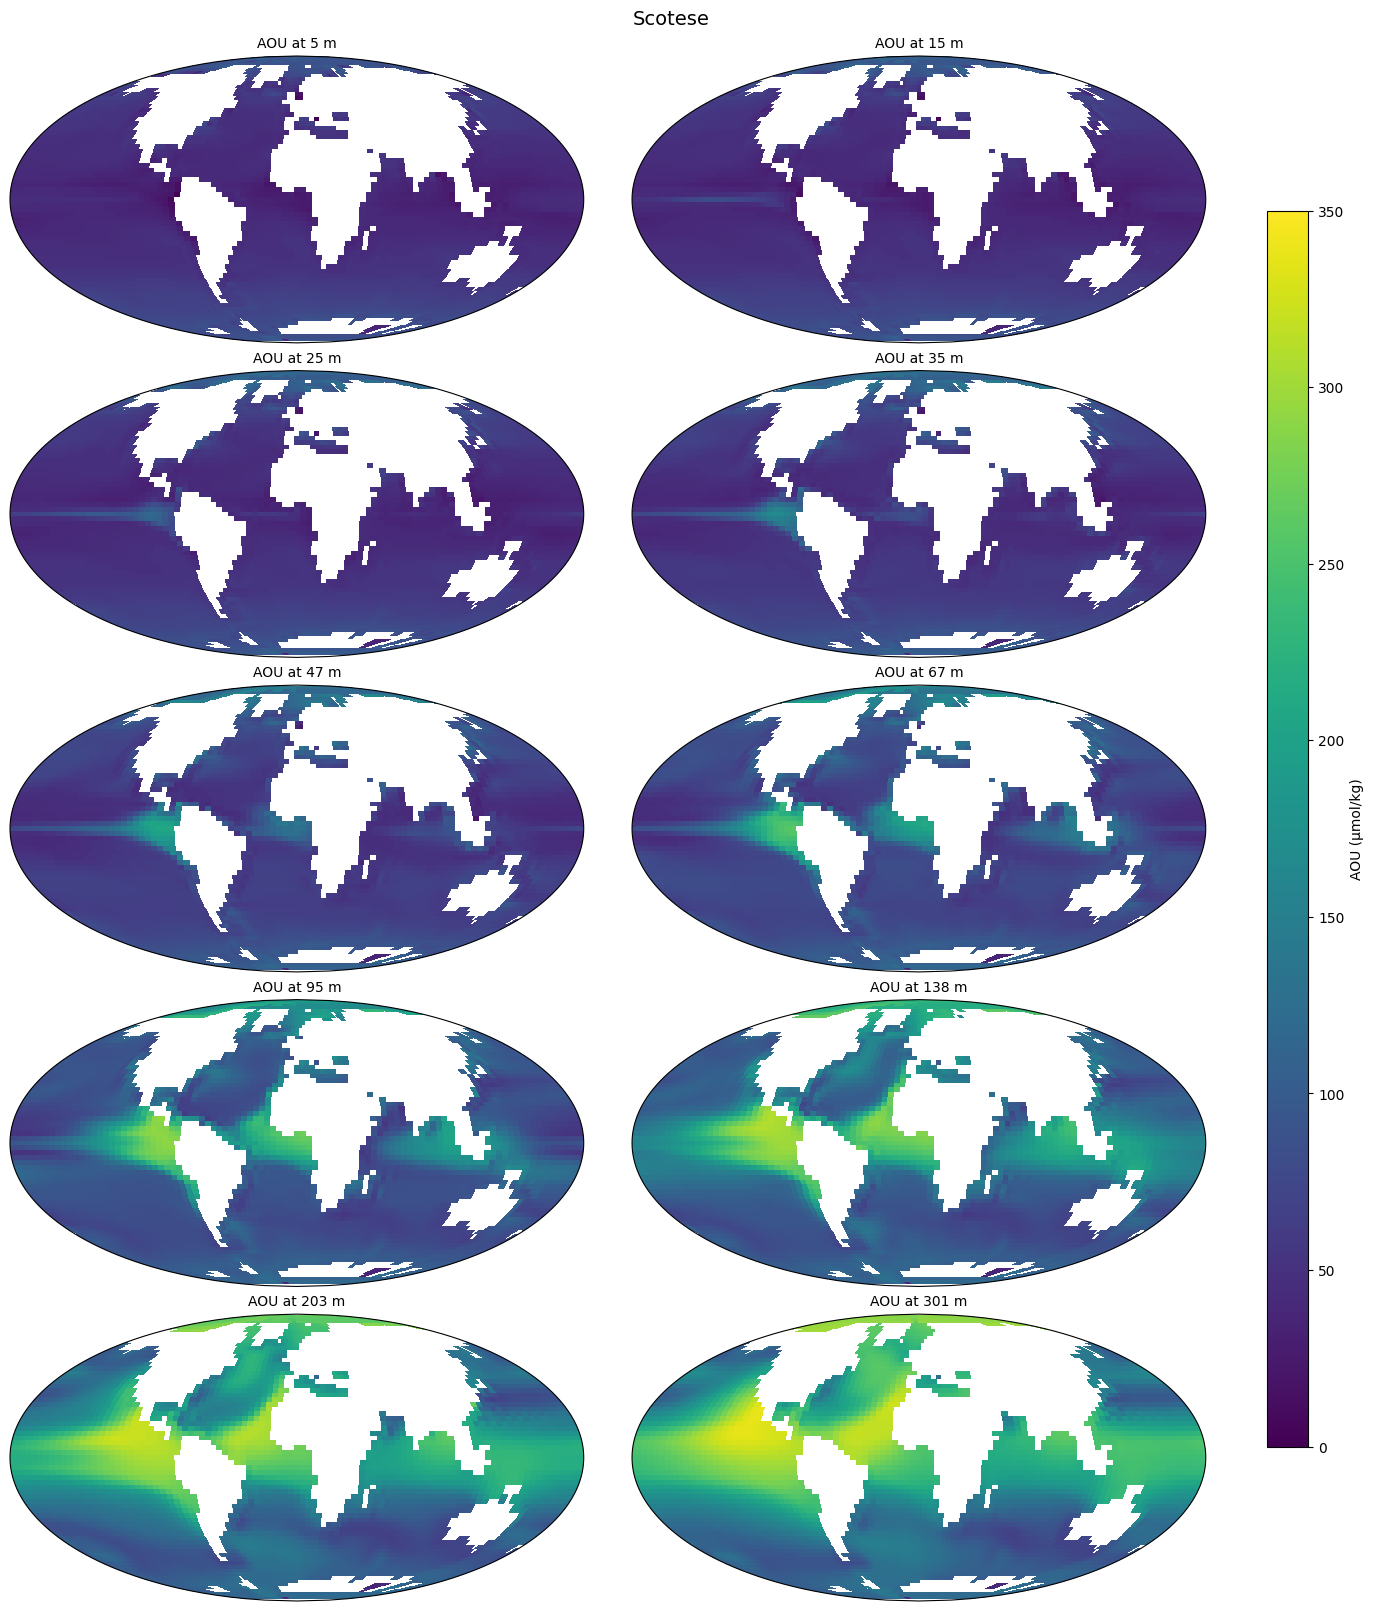

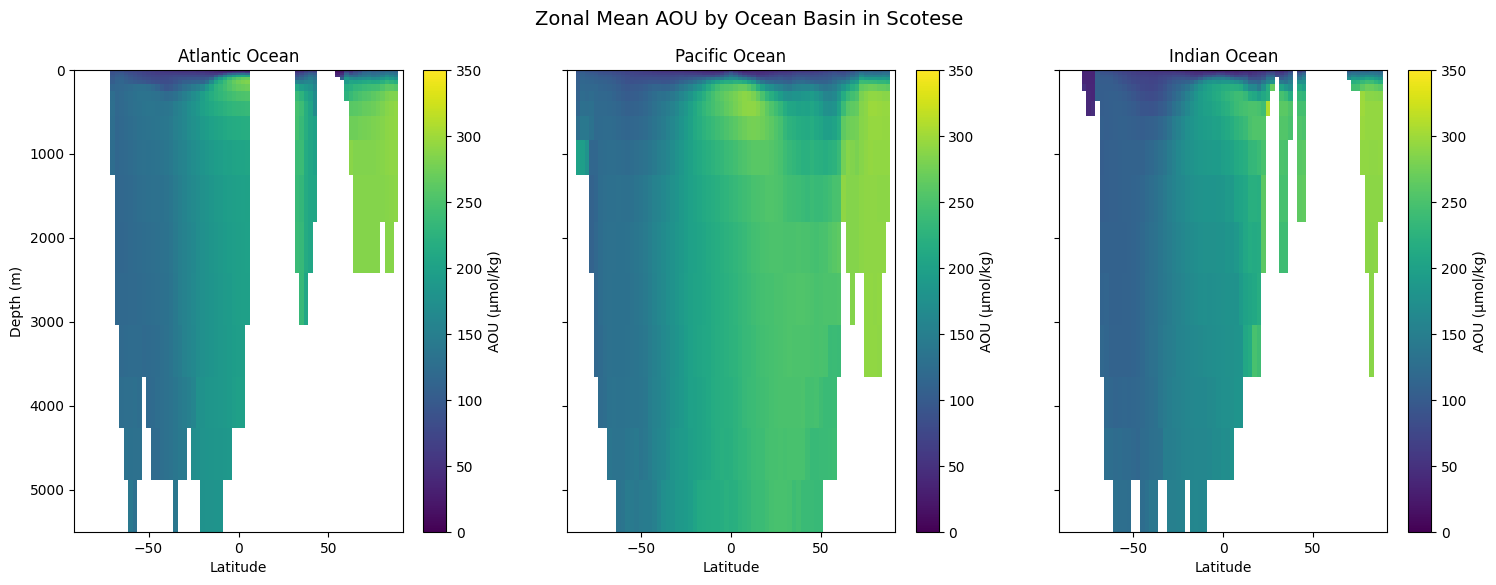

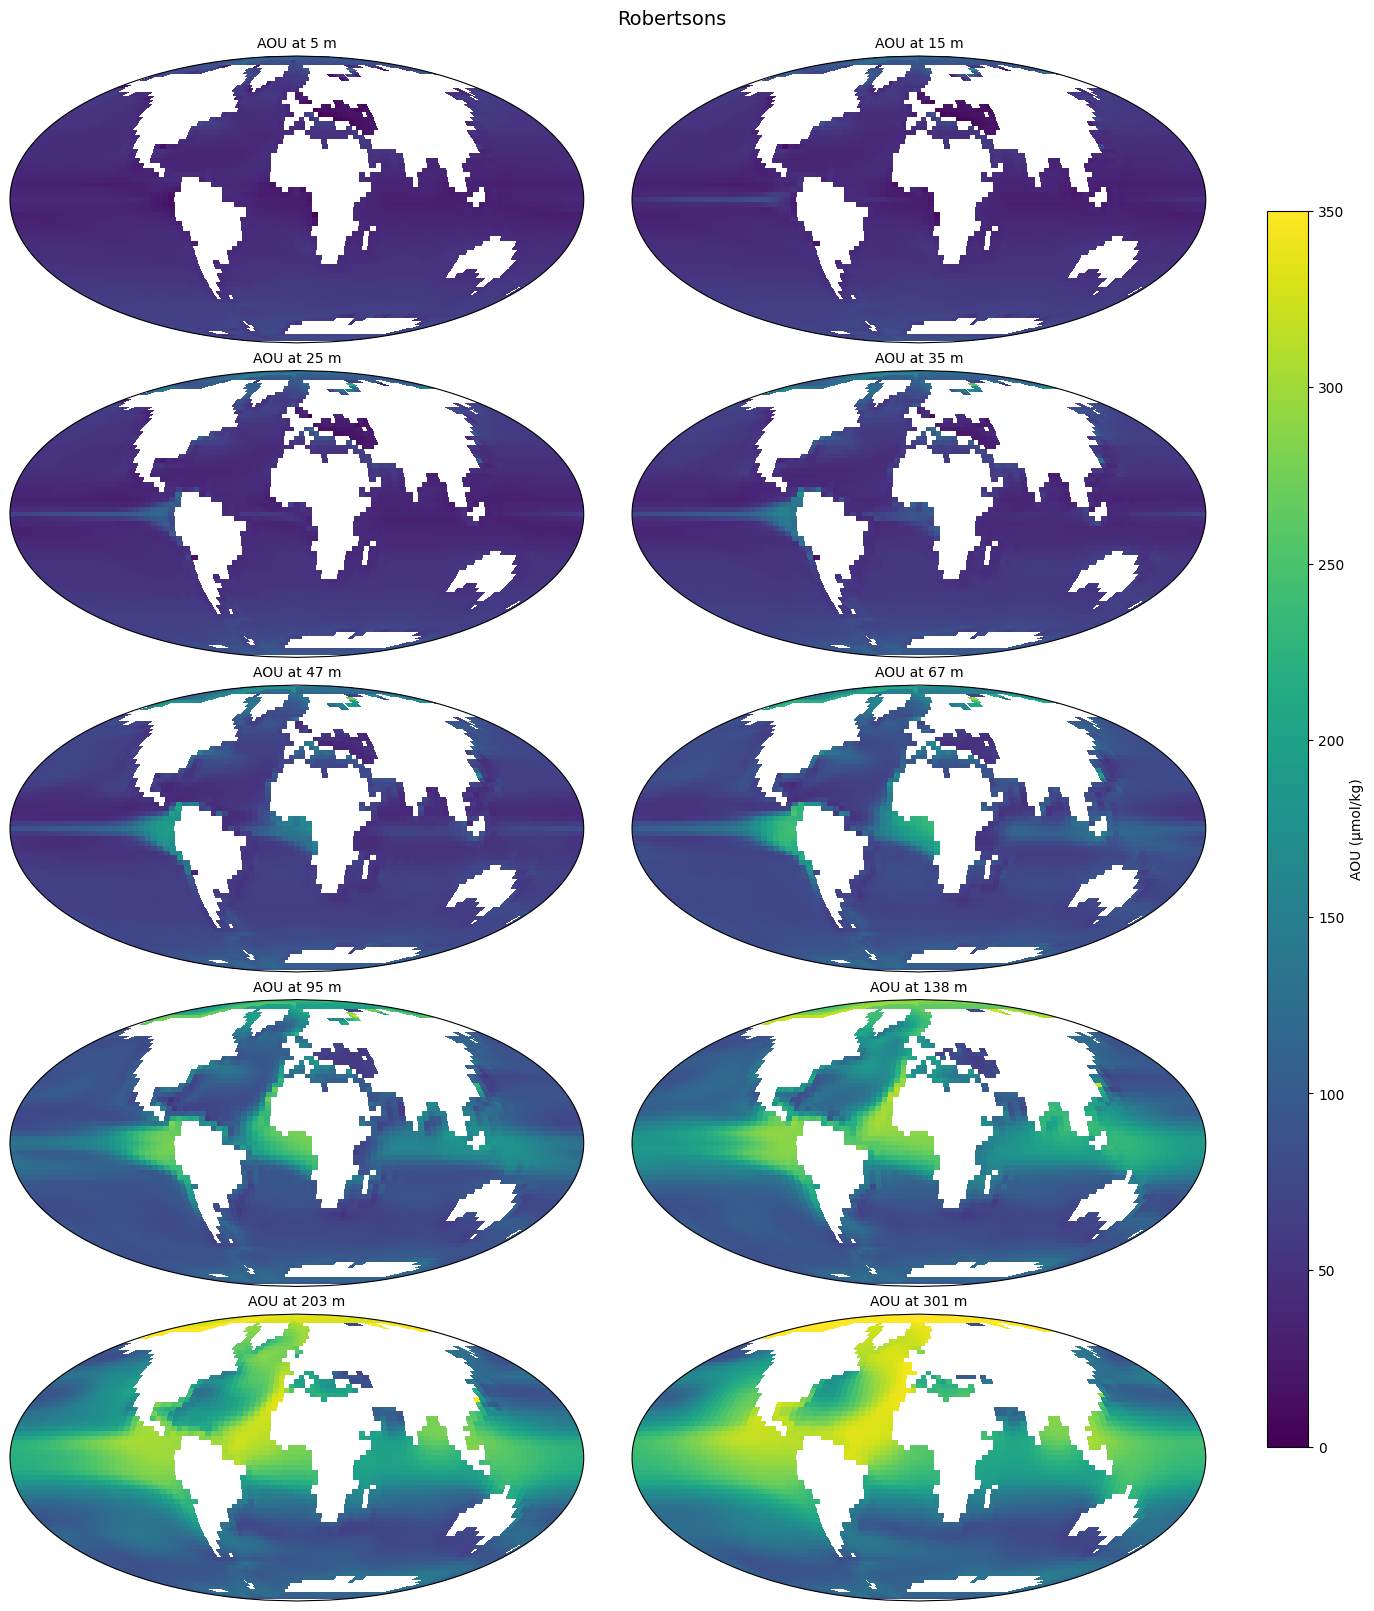

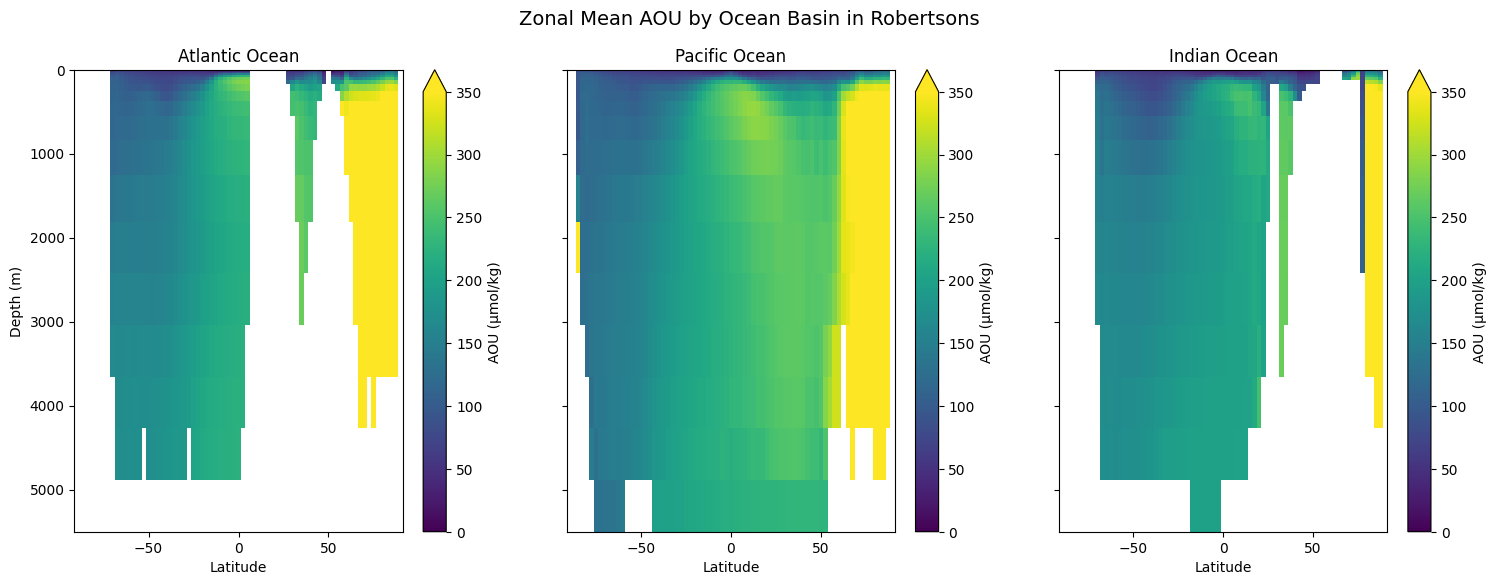

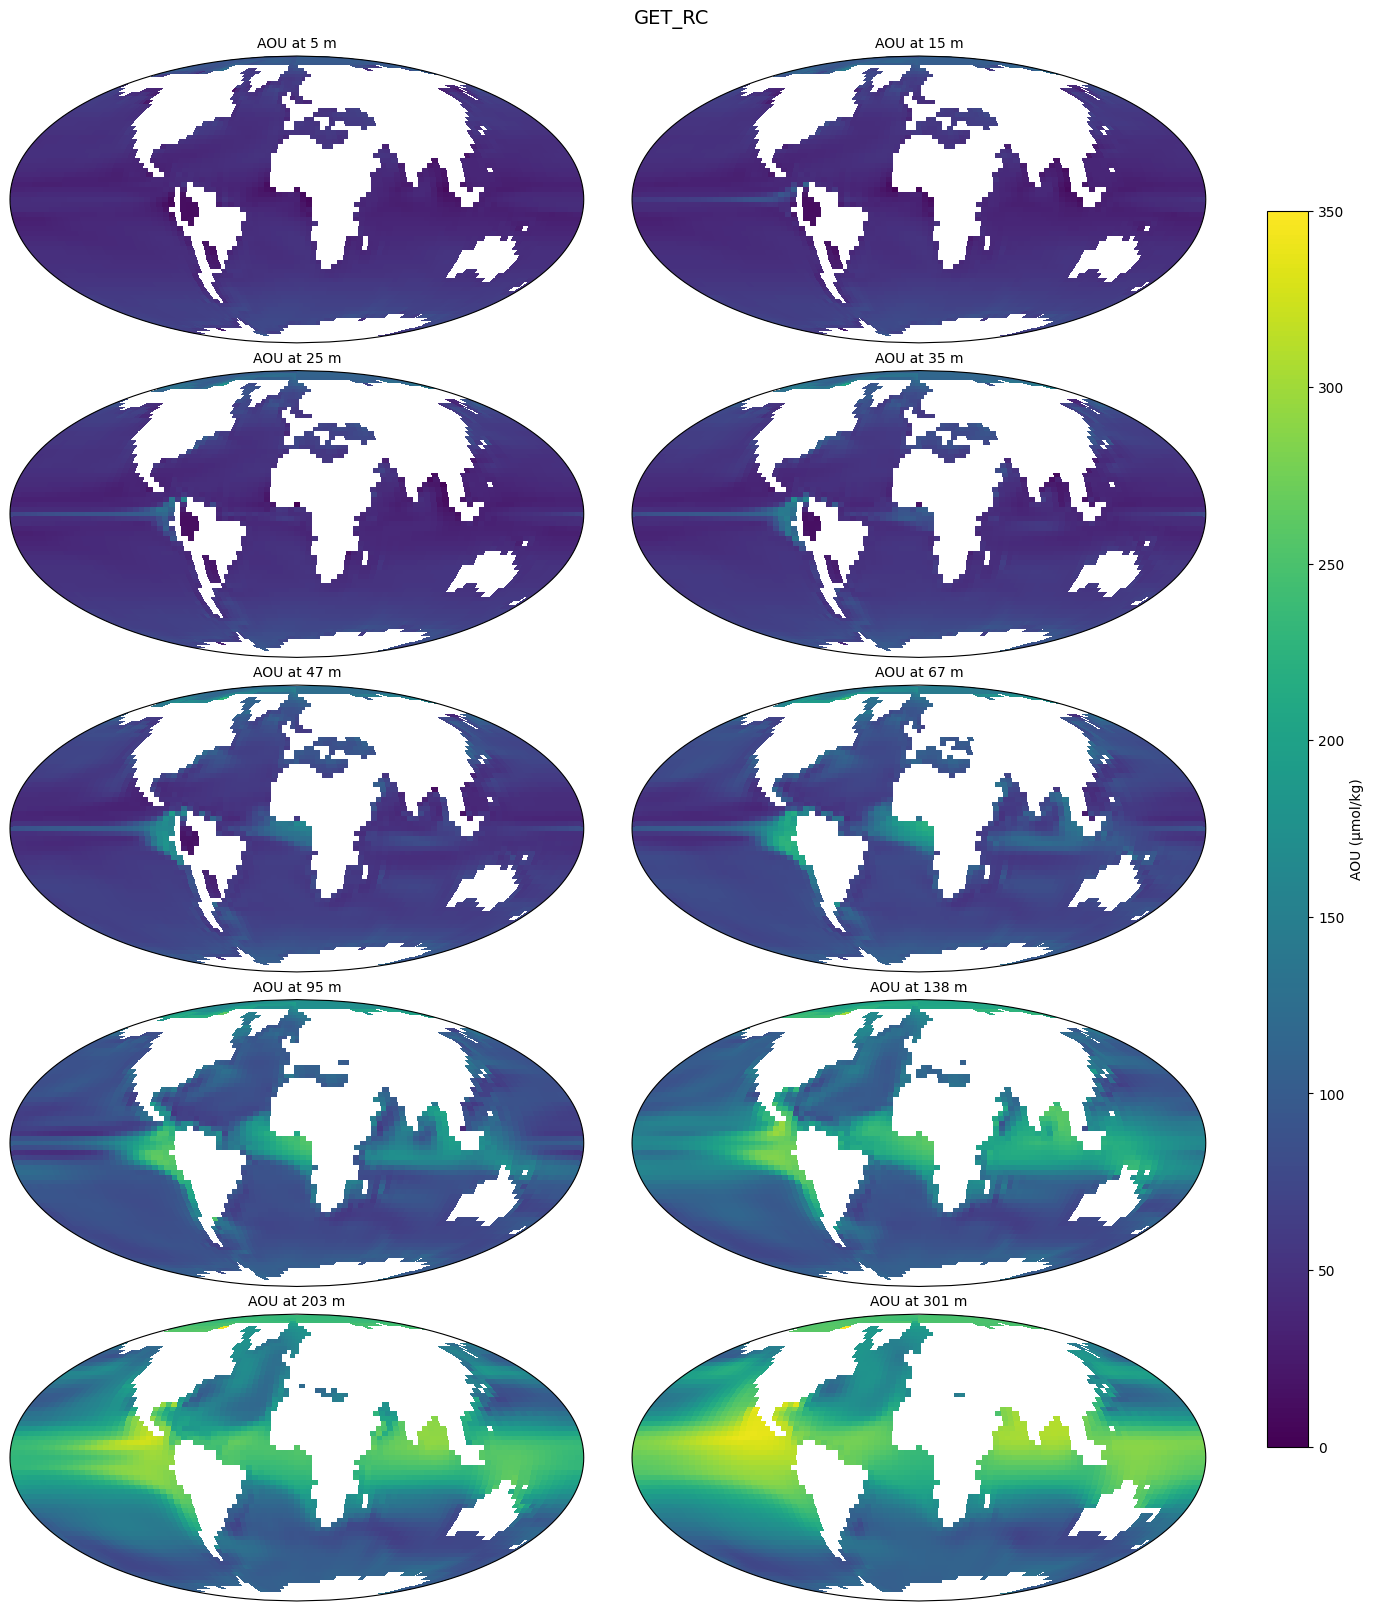

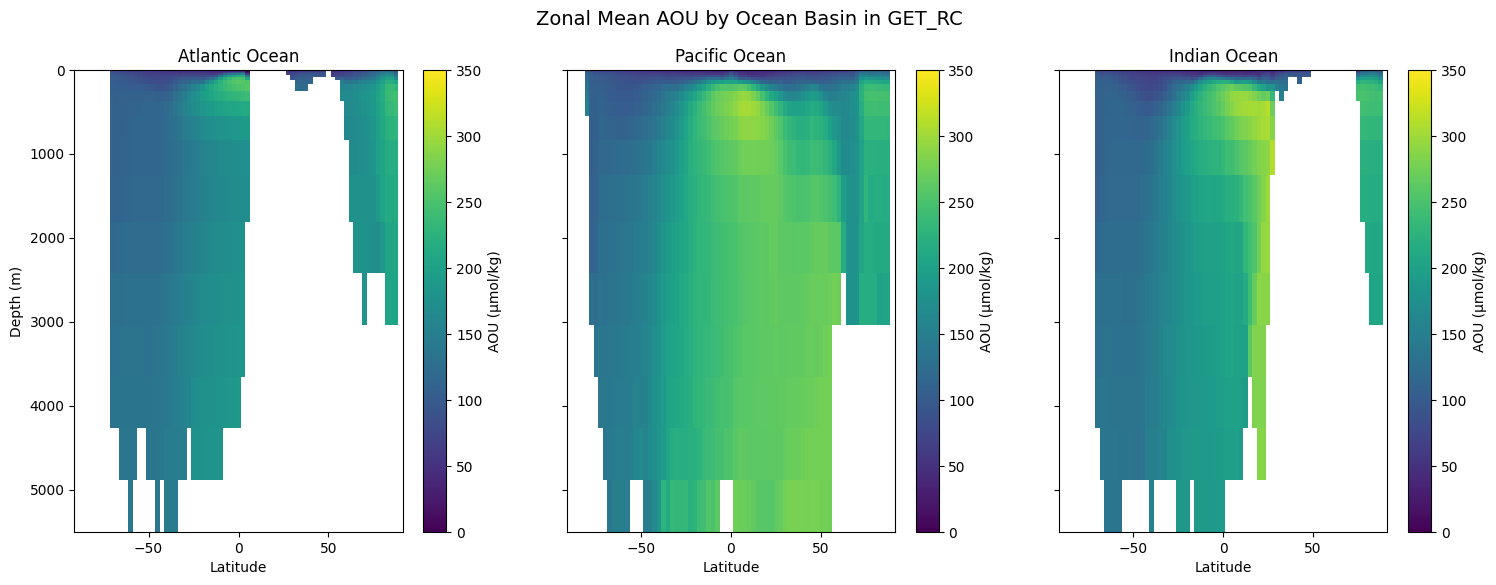

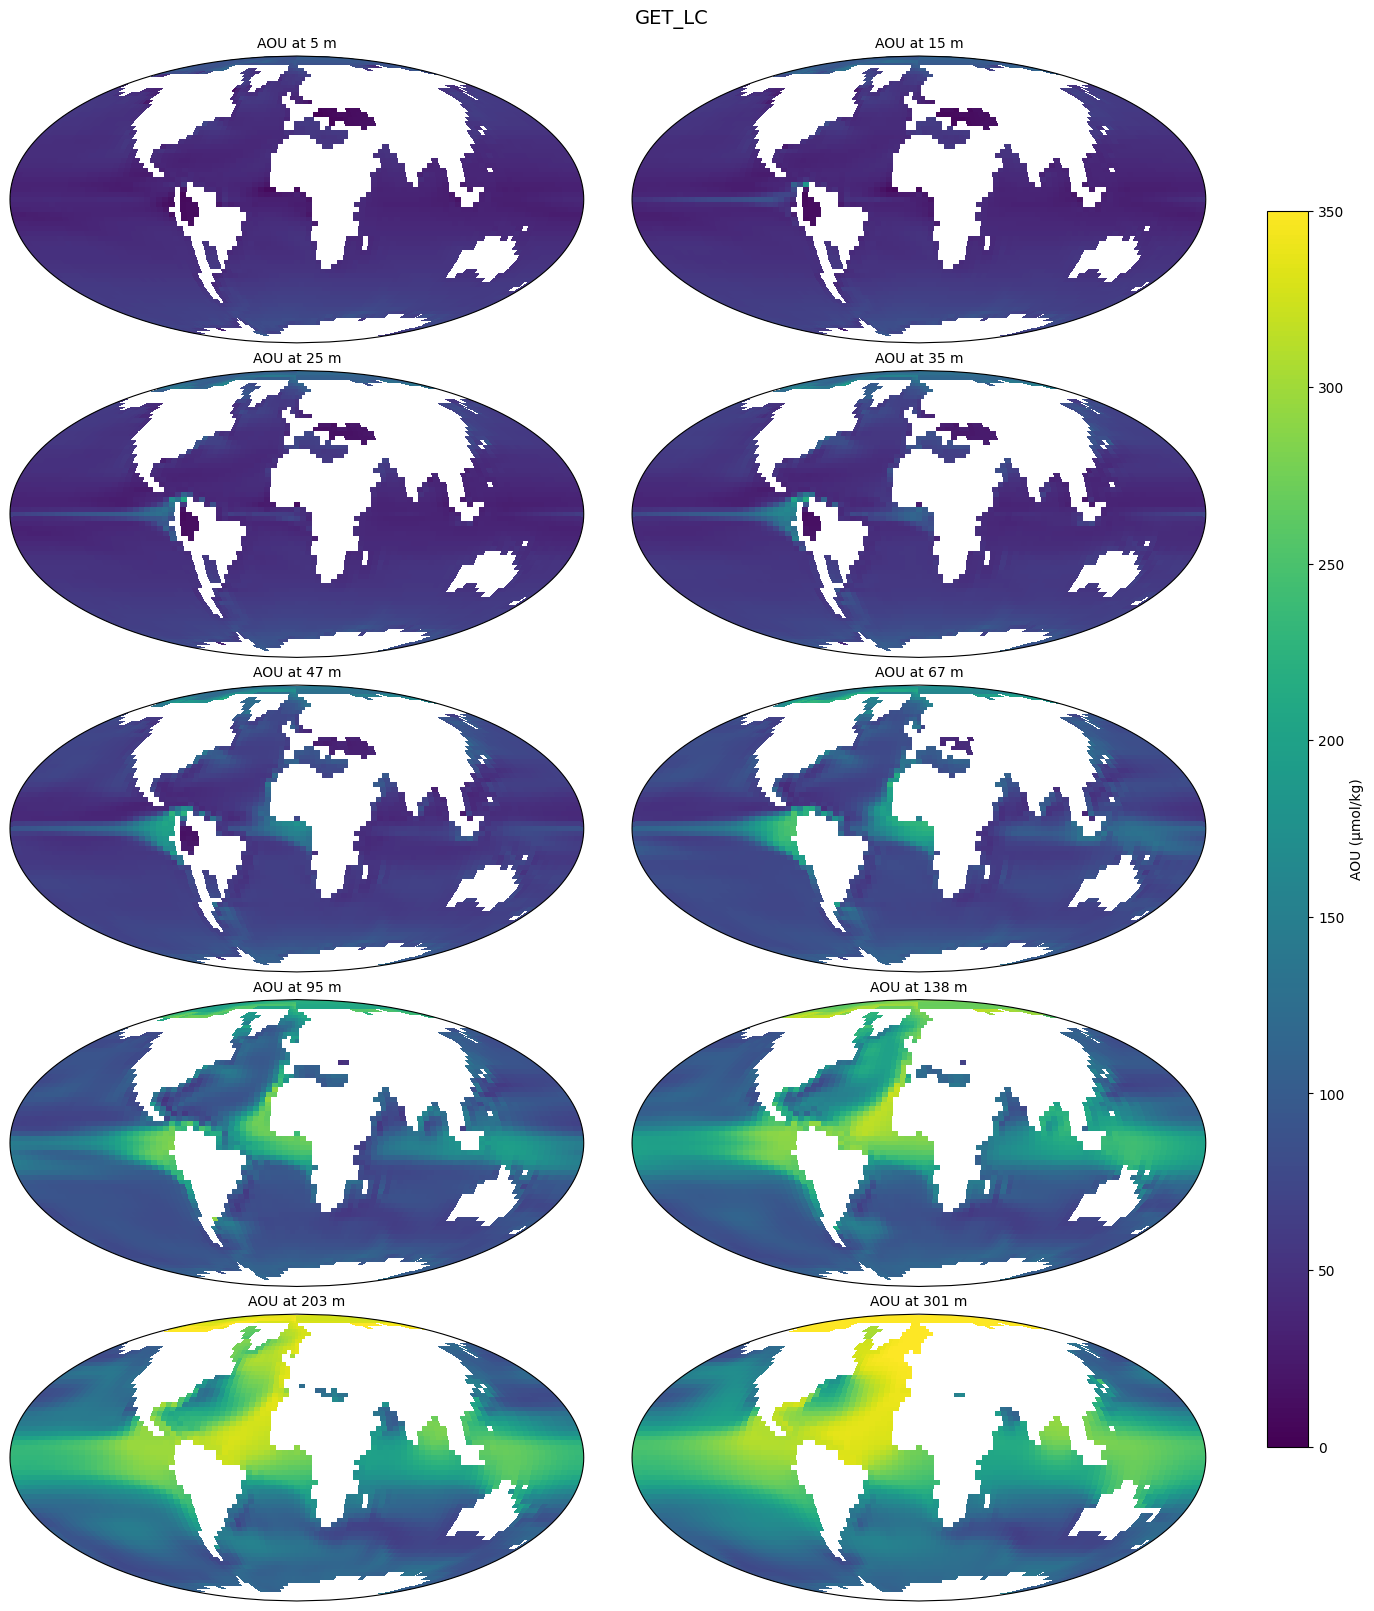

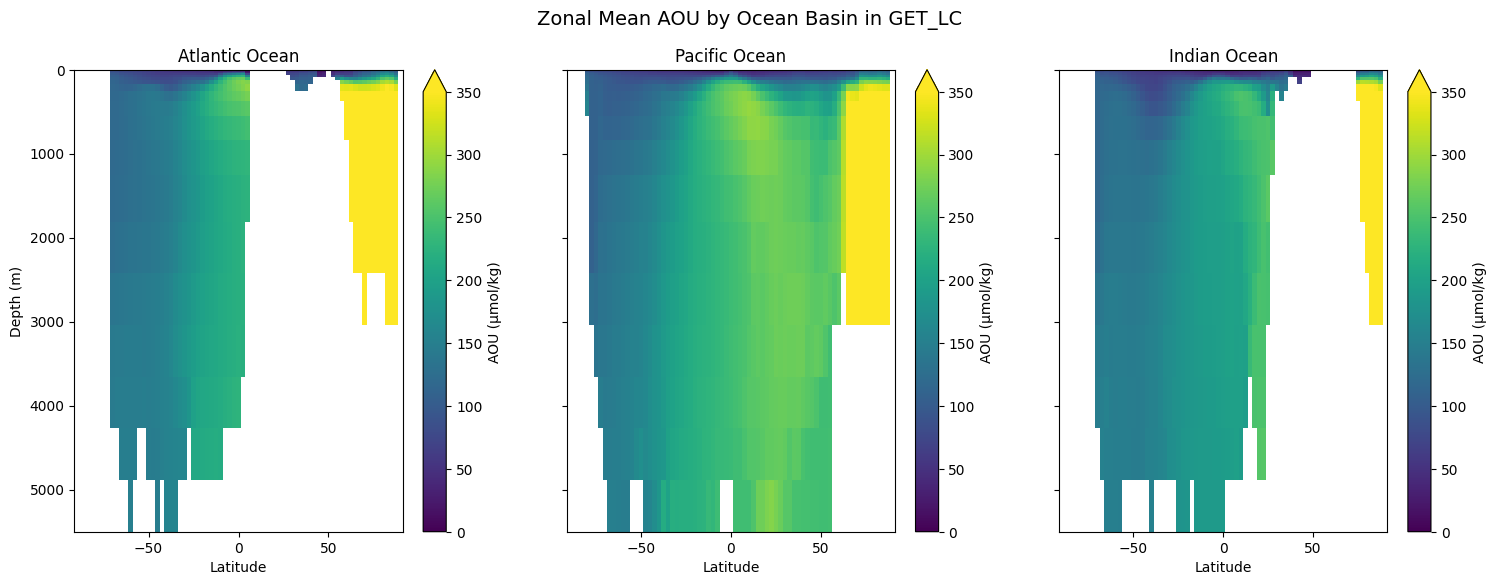

In [16]:
# loop over ds_list
for i, ds in enumerate(ds_list):
    aou = ds['AOU']
    # plots for vertical layers
    rows, cols =5, 2
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(14,16), constrained_layout=True,
                            subplot_kw={'projection': ccrs.Mollweide()})
    for d, ax in zip(range(rows * cols), axs.ravel()):
        im = ax.pcolormesh(lon, lat, aou.isel(t=0, depth_2=d), shading='auto', cmap='viridis',
                           vmin=0, vmax=350, transform=ccrs.PlateCarree())
        ax.set_title(f"AOU at {int(depth[d].values)} m", fontsize=10)
    # plt.colorbar(im, label='AOU (µmol/kg)')
    fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', label='AOU (µmol/kg)',
                 shrink=0.8, aspect=30)
    fig.suptitle(dscb_list[i], fontsize=14)

    # export figure
    # dir_outpath = os.path.join(dir_out, f"AOU_depth_layers_{dscb_list[i]}.png")
    # fig.savefig(dir_outpath, dpi=300,)

    # plots for zonal means
    # Ocean basin masks
    basins = {
        "Atlantic": ((lon >= -100) & (lon <= 20)),
        "Pacific": ((lon >= 120) | (lon <= -70)),
        "Indian": ((lon >= 20) & (lon <= 120)),
    }

    fig1, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    # Zonal mean plots
    for j, (name, mask) in enumerate(basins.items()):
        ax = axs[j]
        aou_basin = aou.where(mask, drop=True)
        zonal_mean = aou_basin.mean(dim="longitude", skipna=True)

        im = zonal_mean.plot(ax=ax, y="depth_2", yincrease=False, cmap="viridis", 
                             vmin=0, vmax=350, cbar_kwargs={"label": "AOU (µmol/kg)"})
        ax.set_title(f"{name} Ocean")
        ax.set_xlabel("Latitude")
        # for first column only set up y label
        if j == 0:
            ax.set_ylabel("Depth (m)")
        else:
            ax.set_ylabel("")

    # fig.colorbar(im, ax=axs.ravel().tolist(), label="AOU (µmol/kg)", orientation='vertical')

    fig1.suptitle(f"Zonal Mean AOU by Ocean Basin in {dscb_list[i]}", fontsize=14)

    # export figure
    # dir_outpath1 = os.path.join(dir_out, f"AOU_zonal_mean_ocean_basins_{dscb_list[i]}.png")
    # fig1.savefig(dir_outpath1, dpi=300)

In [ ]:
# Assume ds_list contains your datasets with computed AOU
# Get AOU ranges
aou_min = float('inf')
aou_max = float('-inf')

for i, ds in enumerate(ds_list):
    print(dscb_list[i])
    aou_min = float(ds['AOU'].min())
    aou_max = float(ds['AOU'].max())
    print(f"Min AOU: {aou_min}, Max AOU: {aou_max}")

print(f"Global AOU range: {aou_min} to {aou_max}")

GETECH
Min AOU: -4.606684429605281, Max AOU: 354.80244298526276
Scotese
Min AOU: 1.0400033156471409, Max AOU: 340.3525318742368
Robertsons
Min AOU: 1.1642829320937835, Max AOU: 471.1784159002296
GET_RC
Min AOU: 1.2578528115806193, Max AOU: 372.7318652675952
GET_LC
Min AOU: 3.614112708365667, Max AOU: 385.42192491930297
Global AOU range: 3.614112708365667 to 385.42192491930297


## Calculate aOUR


In [17]:
# I/O setup
dir_in = '/Users/nd20983/Documents/data/'
data_list = ['xpvha','xpvhb','xpvhc','xpvhr','xpvhw',]
dscb_list = ['GETECH','Scotese','Robertsons','GET_RC','GET_LC']
file_tail = 'o.pgclann.nc'
dir_out = os.path.abspath(os.path.join(
    os.getcwd(), '..','..','Simulations','data','OBM','figures'))
os.makedirs(dir_out, exist_ok=True)
# dir_outpath = os.path.join(dir_out, f"AOU_map_{i}.png")

# read in files
ds_list = []
for data in data_list:
    filename = os.path.join(dir_in, data + file_tail)
    # non-standard time units
    ds = xr.open_dataset(filename, decode_times=False)
    # manually convert time to cftime
    ds['t'].attrs['units'] = 'days since 2850-12-01 00:00:00'
    ds = xr.decode_cf(ds)
    ds_list.append(ds)

for i, ds in enumerate(ds_list):
    # get essential variables
    temp = ds['temp_ym_dpth']
    salt = ds['salinity_ym_dpth']
    oxygen = ds['O2_ym_dpth']
    age = ds['agewater_ym_dpth']
    # get coordinates
    lat = ds['latitude']
    lon = ds['longitude']
    depth = ds['depth_2']

    # compute oxygen solubility (in umol/kg)
    O2_sat = gsw.O2sol_SP_pt(salt.values, temp.values)

    # compute AOU
    aou = xr.DataArray(O2_sat - oxygen.values, coords=oxygen.coords, dims=oxygen.dims)
    aou.name = 'AOU'
    aou.attrs["units"] = "µmol/kg"
    aou.attrs["long_name"] = "Apparent Oxygen Utilization"

    # compute aOUR safely
    aour = xr.where(age > 0, aou / age, np.nan)
    aour.name = 'aOUR'
    aour.attrs['units'] = 'µmol/kg/yr'
    aour.attrs['long_name'] = 'Apparent Oxygen Utilization Rate'
    # add to dataset
    ds['AOU'] = aou
    ds['aOUR'] = aour

/var/folders/sq/wfj9lzcx6437thzlt85cgjwr0000gp/T/ipykernel_45977/3700823777.py:19: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.decode_cf(ds)
/var/folders/sq/wfj9lzcx6437thzlt85cgjwr0000gp/T/ipykernel_45977/3700823777.py:19: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.decode_cf(ds)
/var/folders/sq/wfj9lzcx6437thzlt85cgjwr0000gp/T/ipykernel_45977/3700823777.py:19: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warn

In [19]:
# Assume ds_list contains your datasets with computed AOU
# Get AOU ranges
aou_min = float('inf')
aou_max = float('-inf')

for i, ds in enumerate(ds_list):
    print(dscb_list[i])
    aou_min = float(ds['aOUR'].min())
    aou_max = float(ds['aOUR'].max())
    print(f"Min AOUR: {aou_min}, Max AOU: {aou_max}")

print(f"Global AOU range: {aou_min} to {aou_max}")

GETECH
Min AOUR: -0.10059894446523693, Max AOU: 1352535.6430797102
Scotese
Min AOUR: 0.12939393543756753, Max AOU: 326468.2914454572
Robertsons
Min AOUR: 0.07646904734668934, Max AOU: 8855347.757196305
GET_RC
Min AOUR: 0.13582730492176676, Max AOU: 1485769.0221778024
GET_LC
Min AOUR: 0.13820452266755642, Max AOU: 86115762.11628182
Global AOU range: 0.13820452266755642 to 86115762.11628182


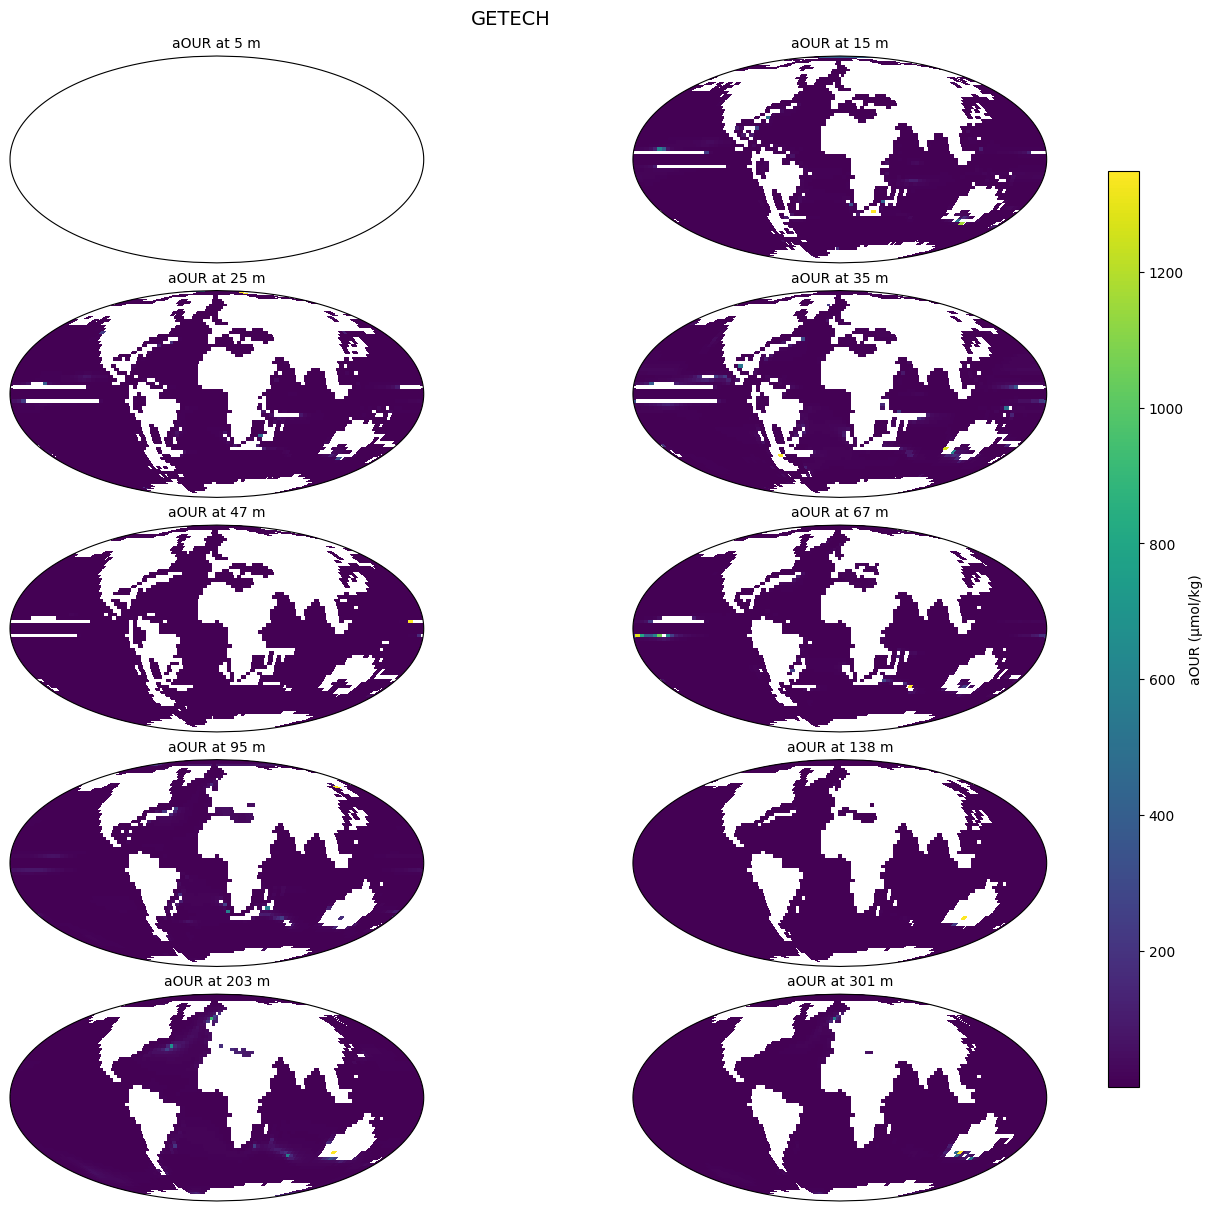

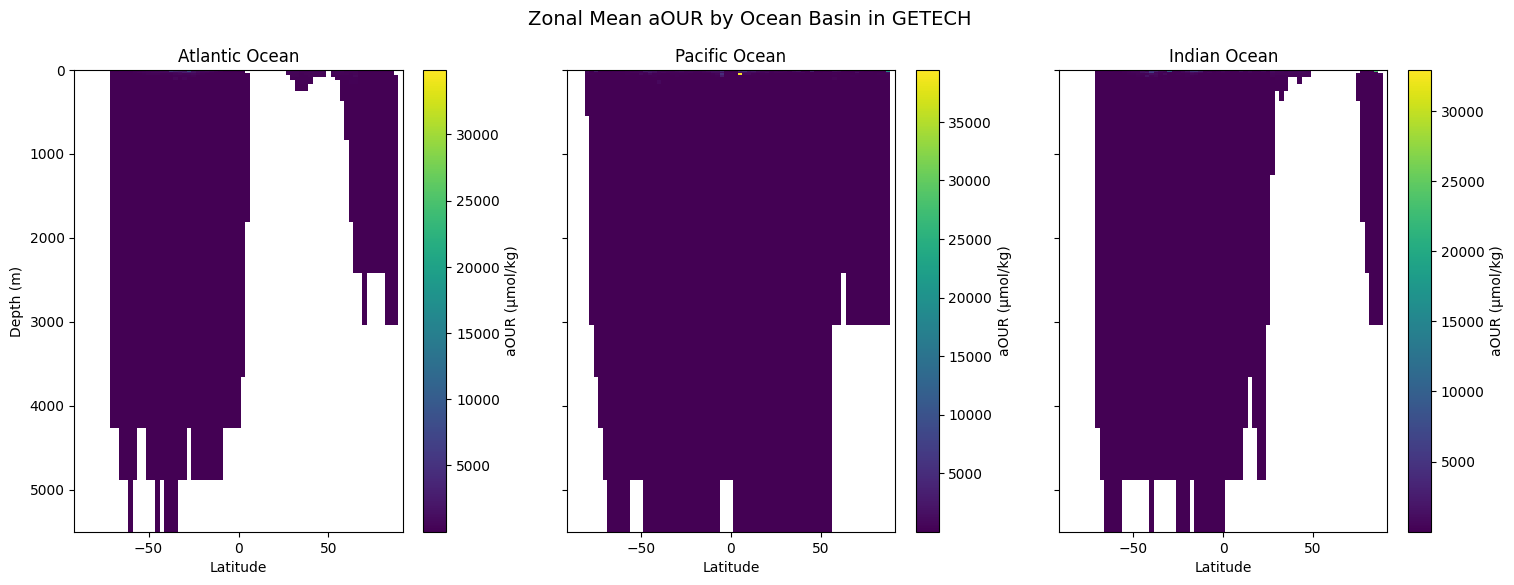

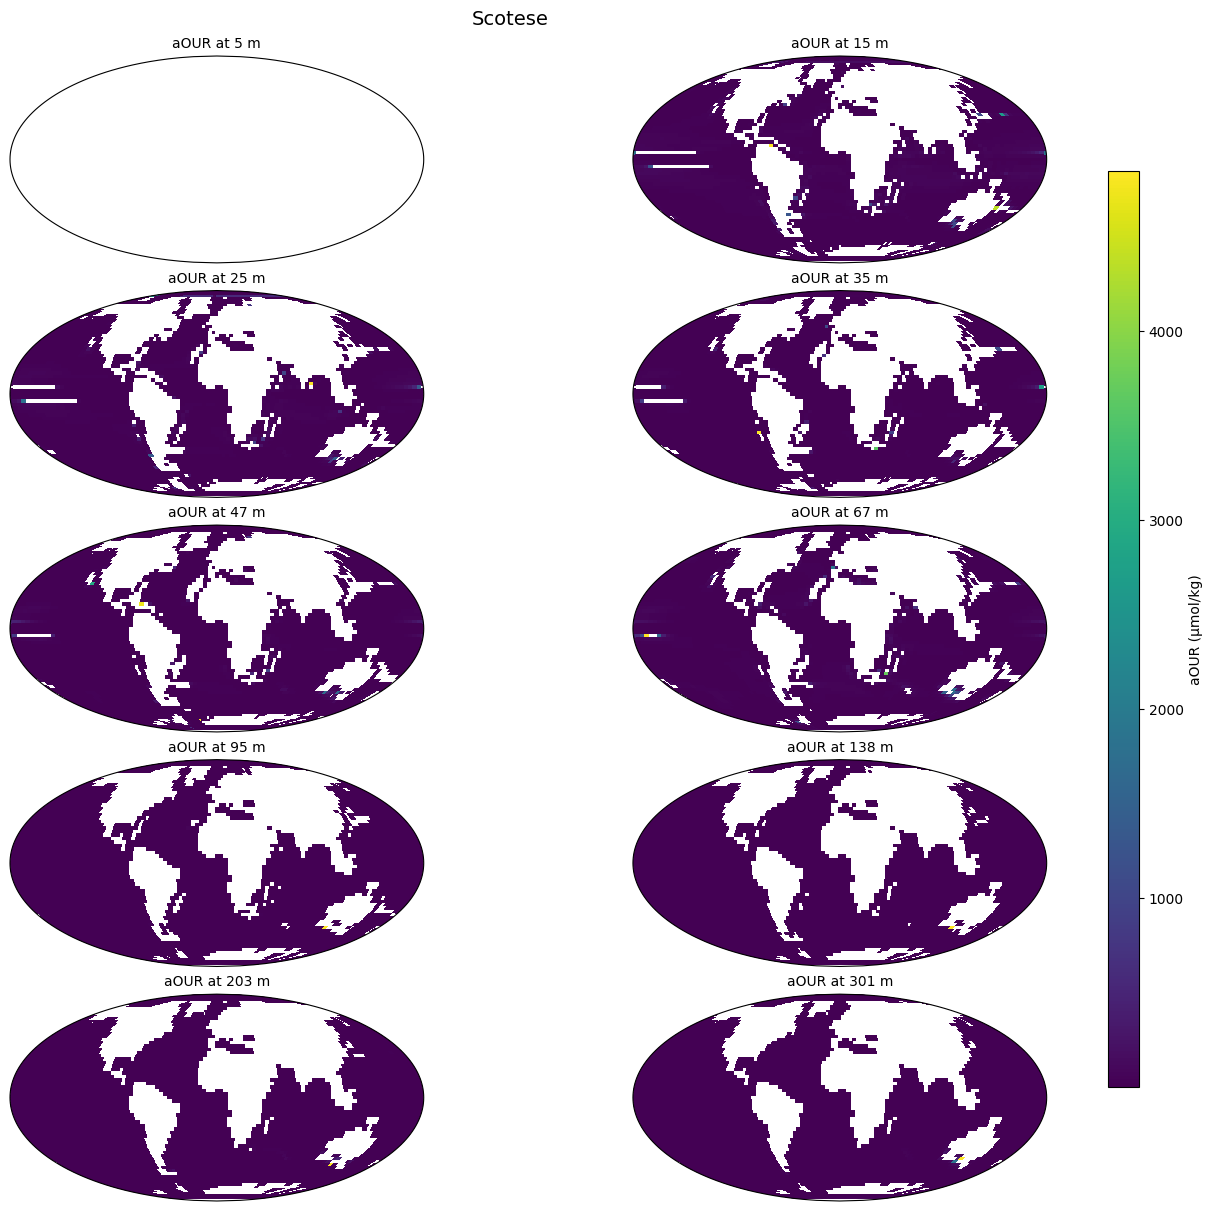

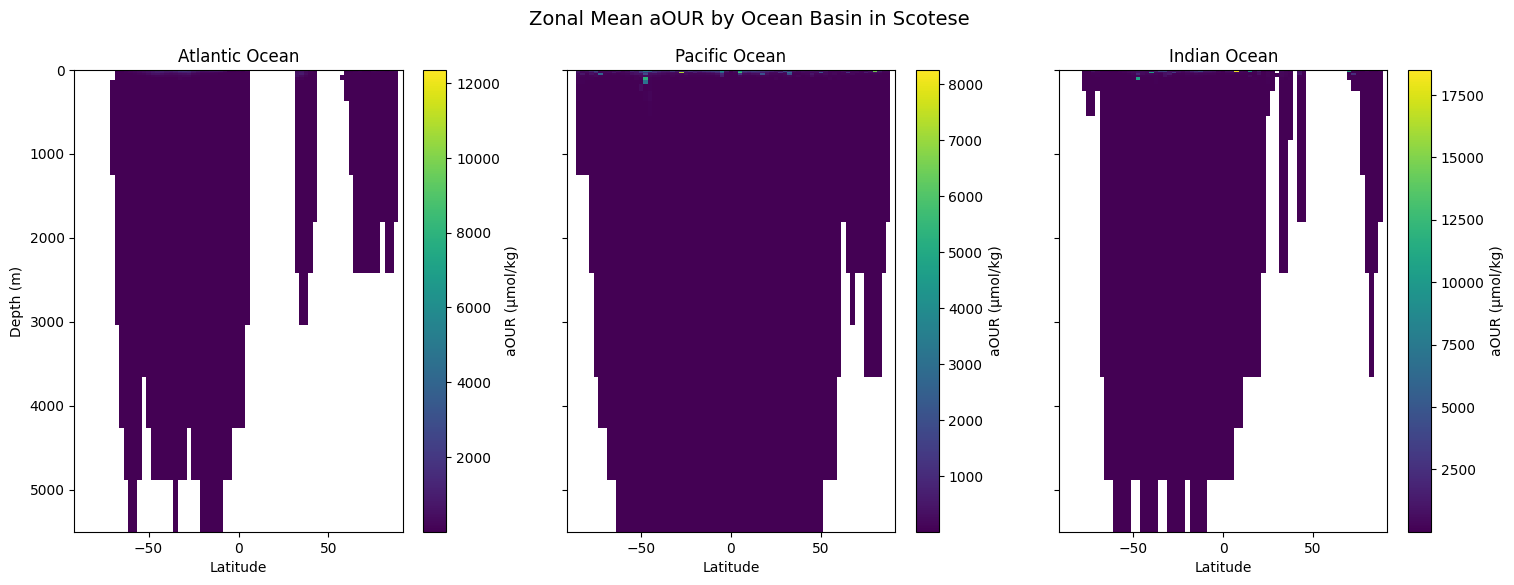

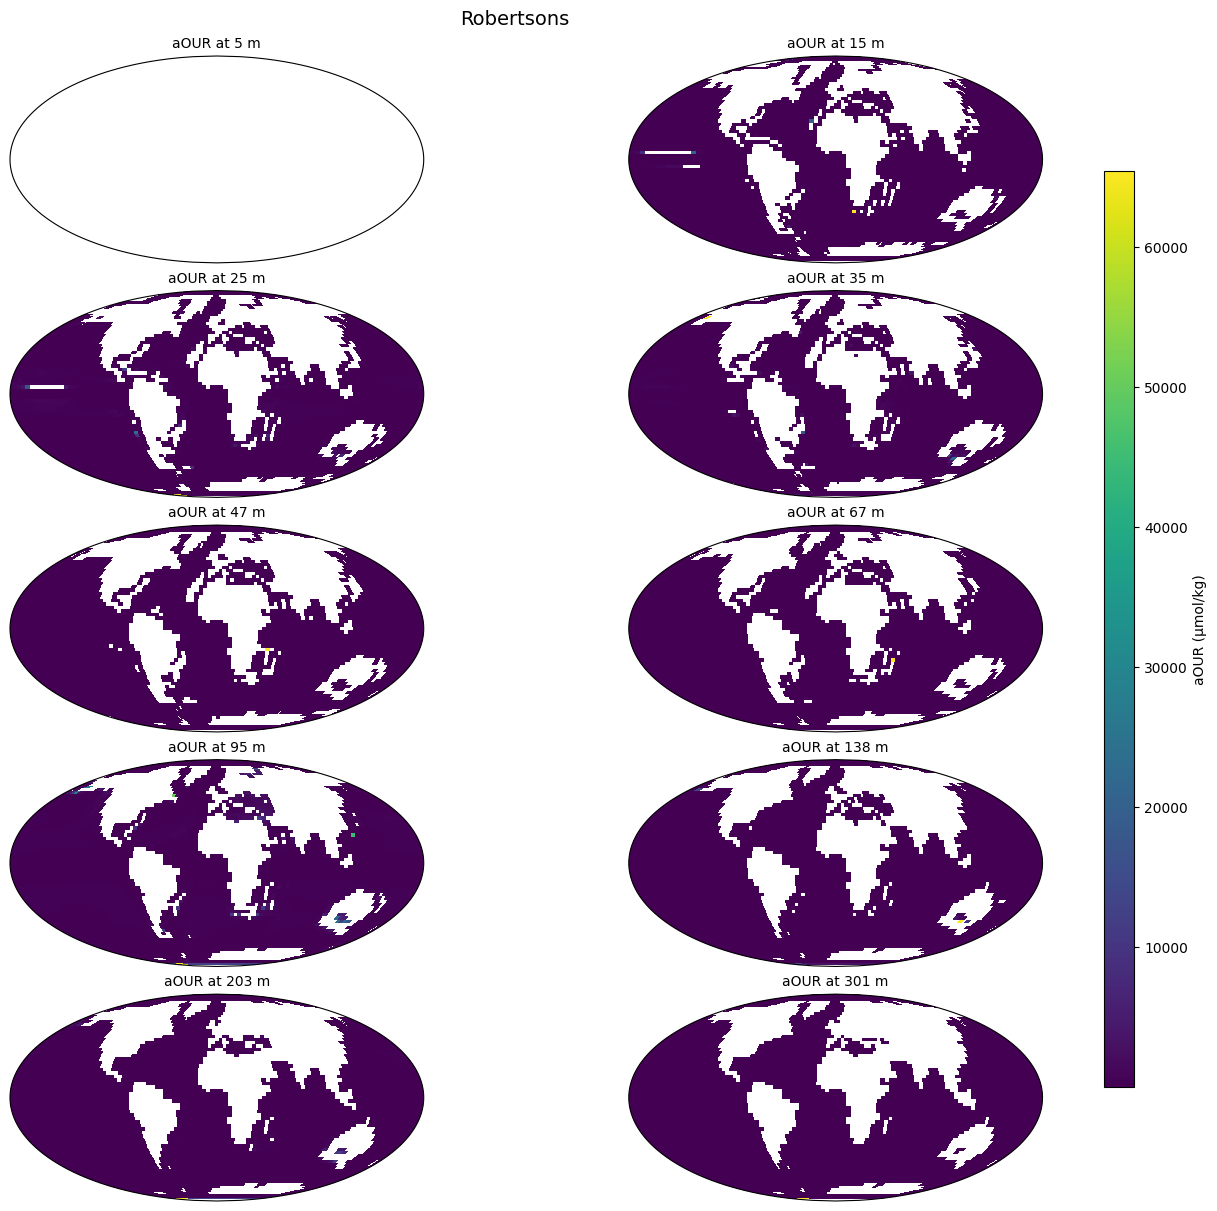

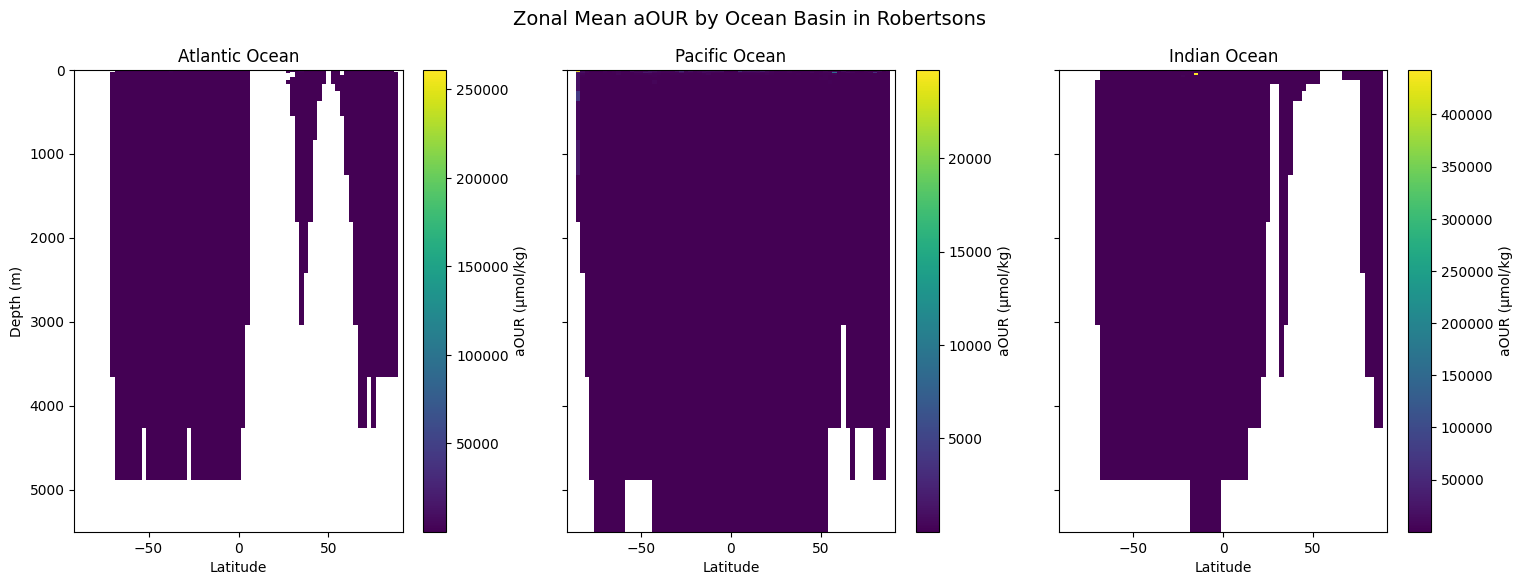

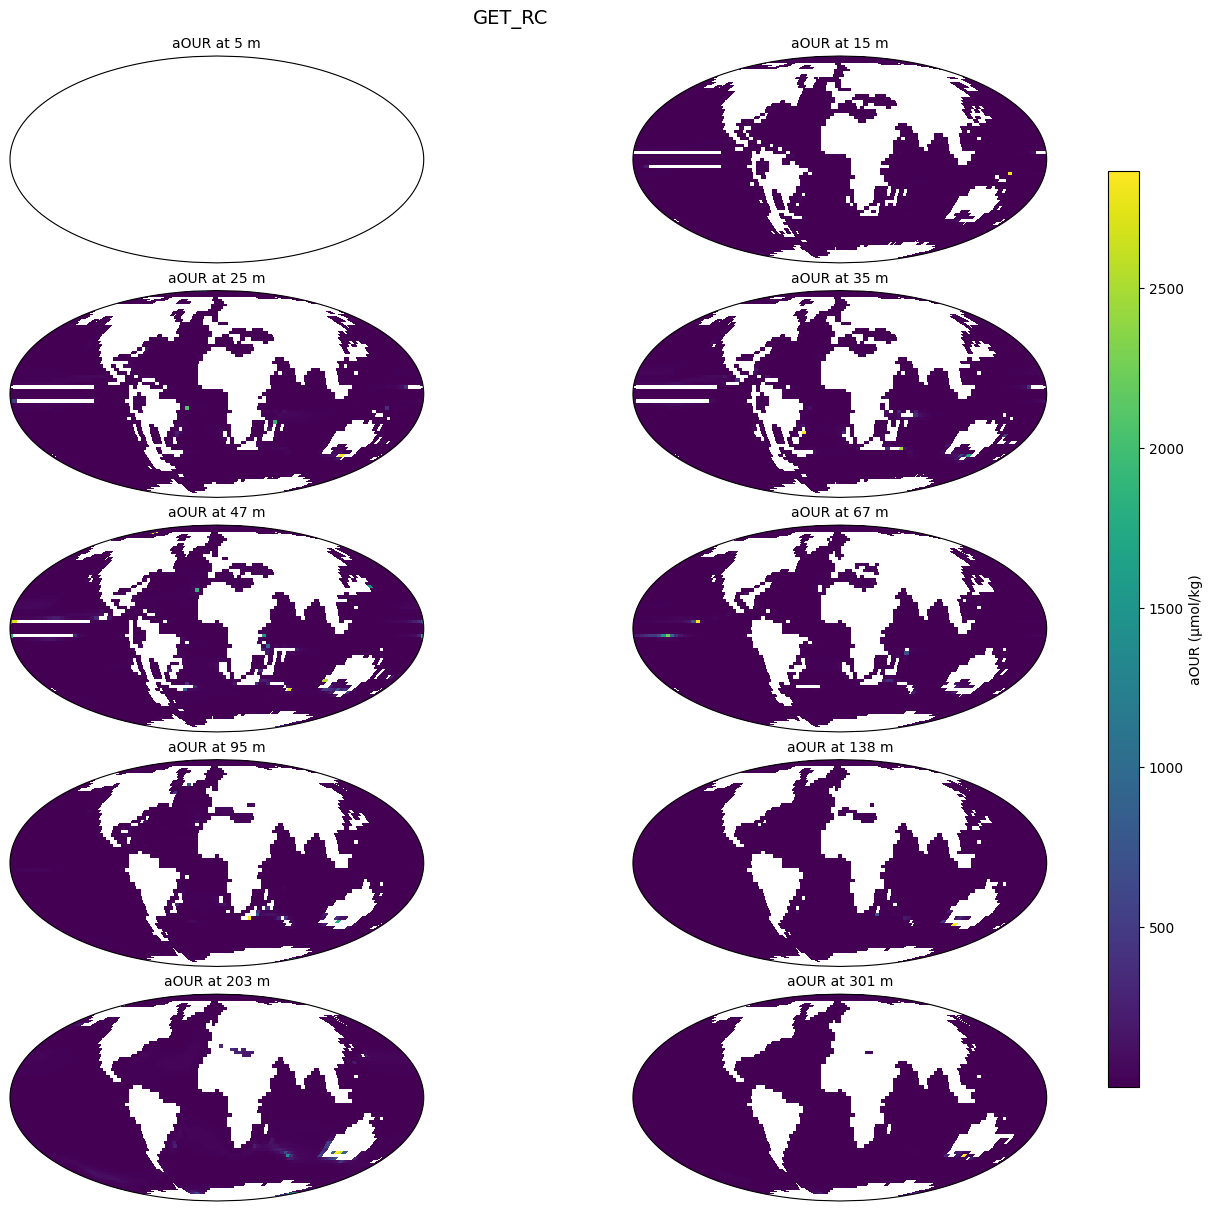

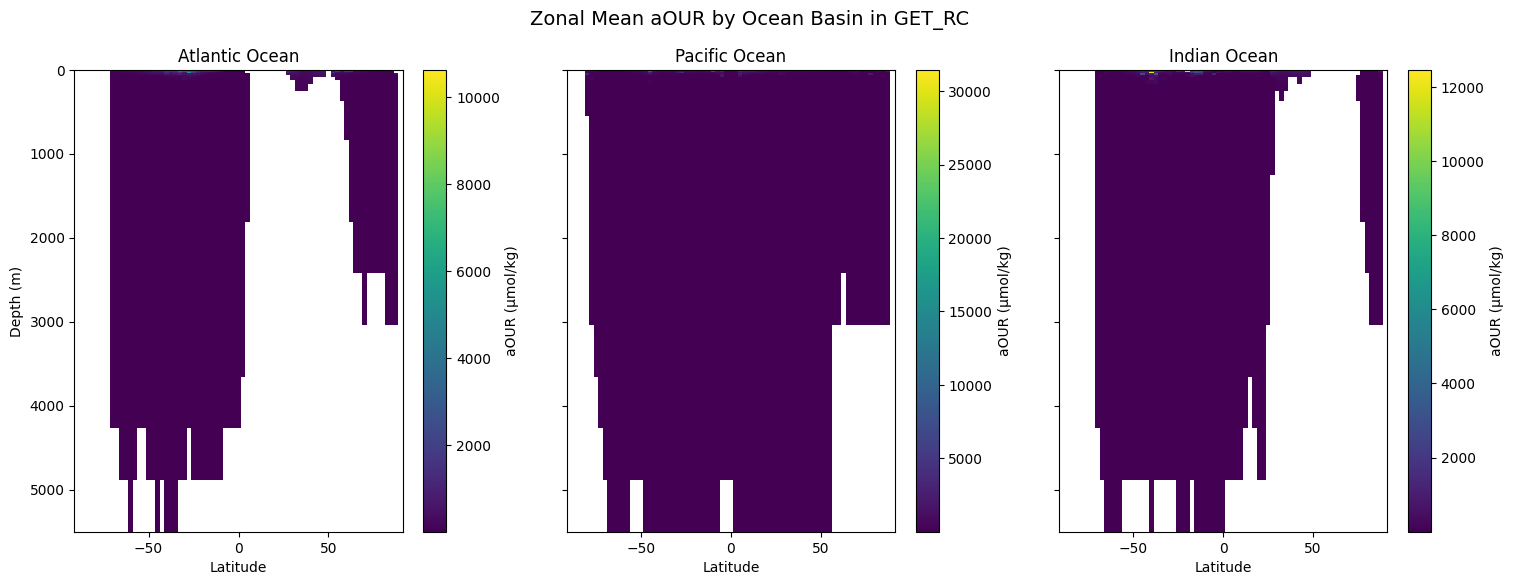

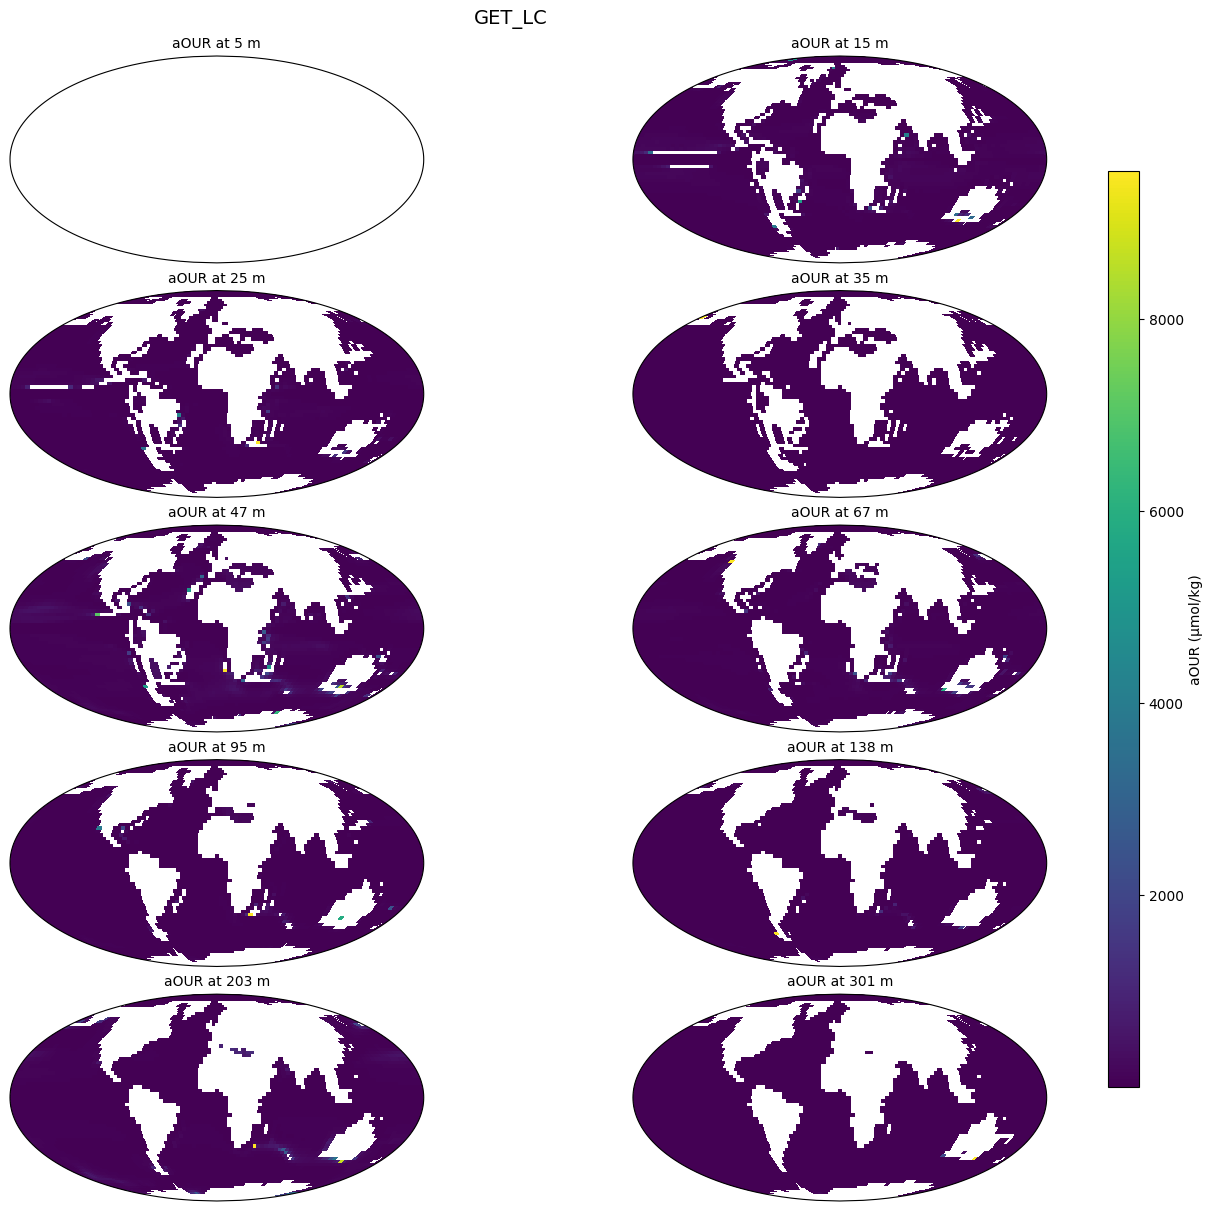

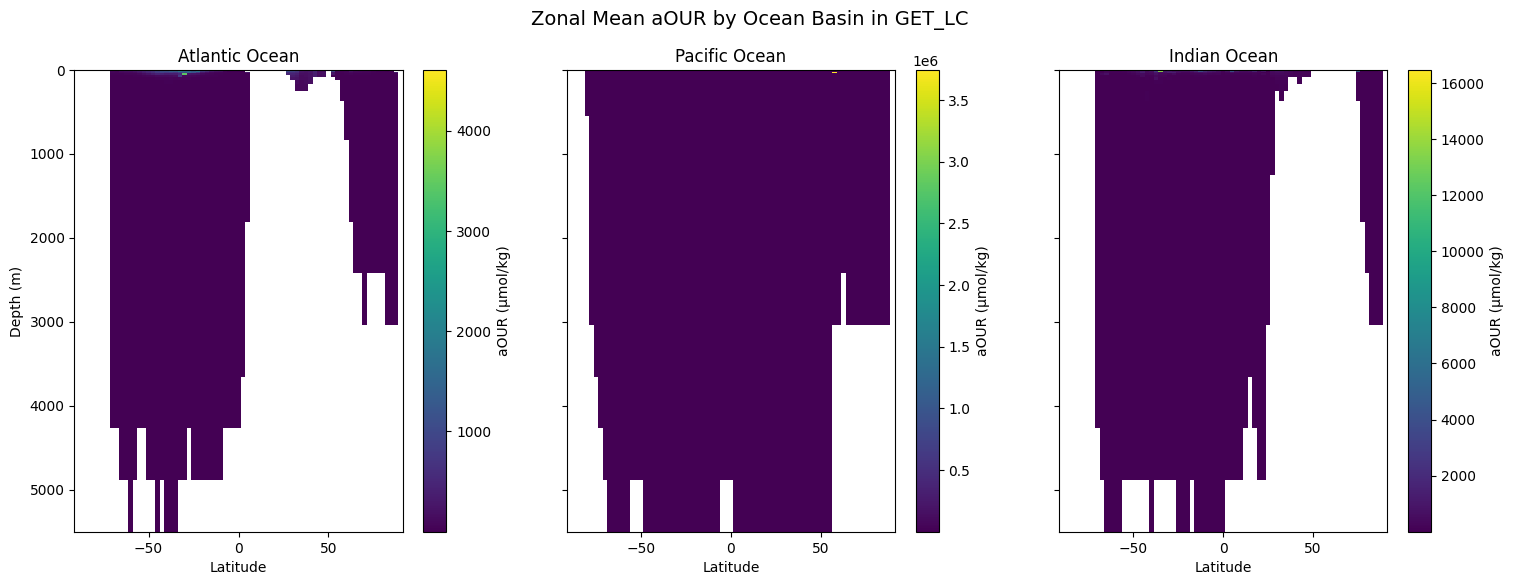

In [21]:
# loop over ds_list
for i, ds in enumerate(ds_list):
    aour = ds['aOUR']
    # plots for vertical layers
    rows, cols =5, 2
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(14,12), constrained_layout=True,
                            subplot_kw={'projection': ccrs.Mollweide()})
    for d, ax in zip(range(rows * cols), axs.ravel()):
        im = ax.pcolormesh(lon, lat, aour.isel(t=0, depth_2=d), shading='auto', cmap='viridis',
                           transform=ccrs.PlateCarree())
        ax.set_title(f"aOUR at {int(depth[d].values)} m", fontsize=10)

    fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', label='aOUR (µmol/kg)',
                 shrink=0.8, aspect=30)
    fig.suptitle(dscb_list[i], fontsize=14)

    # export figure
    # dir_outpath = os.path.join(dir_out, f"AOU_depth_layers_{dscb_list[i]}.png")
    # fig.savefig(dir_outpath, dpi=300,)

    # plots for zonal means
    # Ocean basin masks
    basins = {
        "Atlantic": ((lon >= -100) & (lon <= 20)),
        "Pacific": ((lon >= 120) | (lon <= -70)),
        "Indian": ((lon >= 20) & (lon <= 120)),
    }

    fig1, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    # Zonal mean plots
    for j, (name, mask) in enumerate(basins.items()):
        ax = axs[j]
        aour_basin = aour.where(mask, drop=True)
        zonal_mean = aour_basin.mean(dim="longitude", skipna=True)

        im = zonal_mean.plot(ax=ax, y="depth_2", yincrease=False, cmap="viridis", 
                             cbar_kwargs={"label": "aOUR (µmol/kg)"})
        ax.set_title(f"{name} Ocean")
        ax.set_xlabel("Latitude")
        # for first column only set up y label
        if j == 0:
            ax.set_ylabel("Depth (m)")
        else:
            ax.set_ylabel("")

    # fig.colorbar(im, ax=axs.ravel().tolist(), label="aOUR (µmol/kg)", orientation='vertical')

    fig1.suptitle(f"Zonal Mean aOUR by Ocean Basin in {dscb_list[i]}", fontsize=14)

    # export figure
    # dir_outpath1 = os.path.join(dir_out, f"aOUR_zonal_mean_ocean_basins_{dscb_list[i]}.png")
    # fig1.savefig(dir_outpath1, dpi=300)

### test 3d plot here

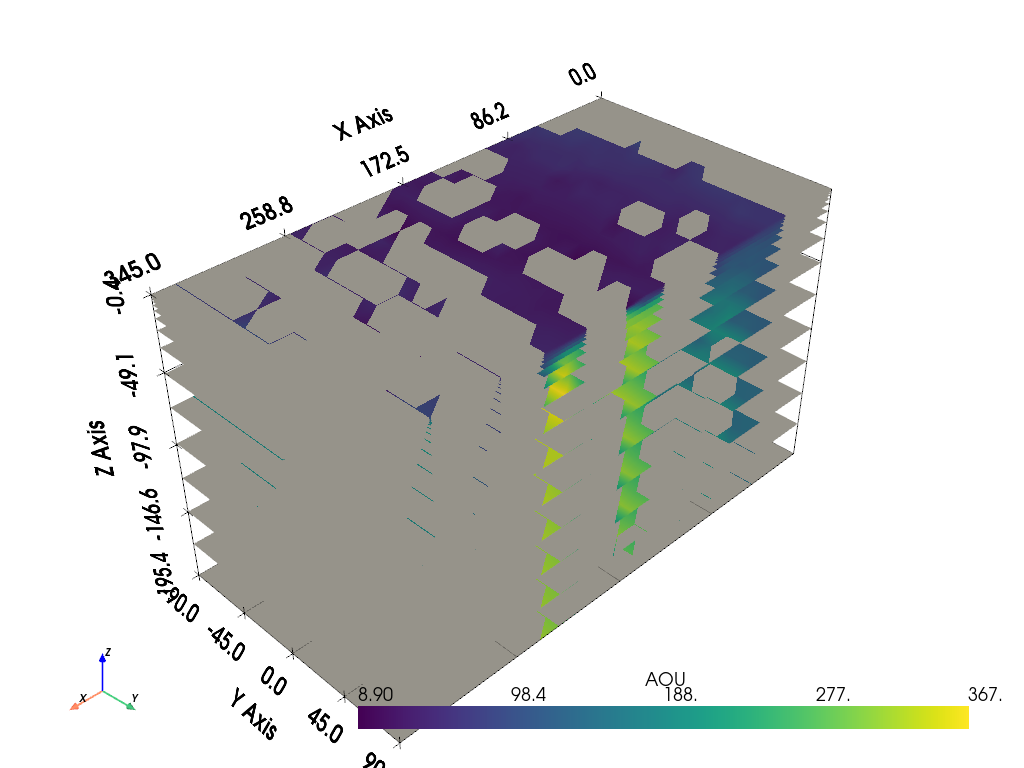

In [13]:
# test 3d volume here
import pyvista as pv
pv.set_jupyter_backend('static')

# get essential variables
ds = ds_list[0]

# add to dataset
aou = ds['AOU'].isel(t=0)

# Get coordinate arrays
lon = ds['longitude'].values
lat = ds['latitude'].values
depth = ds['depth_2'].values

# Downsample to reduce size
aou = aou.isel(longitude=slice(None, None, 4), latitude=slice(None, None, 4))
lon = lon[::4]
lat = lat[::4]

# Meshgrid in lon-lat plane
lon2d, lat2d = np.meshgrid(lon, lat, indexing='ij')

# Create a uniform grid for each depth slab
plotter = pv.Plotter()
for k in range(len(depth) - 1):
    z_top = -depth[k]
    z_bot = -depth[k+1]
    z_mid = (z_top + z_bot) / 2

    # AOU at layer k (constant over slab thickness)
    aou_layer = aou.isel(depth_2=k).values

    # Expand to 3D by stacking top and bottom
    nx, ny = aou_layer.shape
    x = lon2d.flatten()
    y = lat2d.flatten()
    z = np.full_like(x, z_mid)

    points = np.column_stack((x, y, z*0.04))
    grid = pv.StructuredGrid()
    grid.points = points
    grid.dimensions = [nx, ny, 1]
    grid["AOU"] = aou_layer.flatten()

    surf = grid.cast_to_unstructured_grid().extract_surface()
    plotter.add_mesh(surf, scalars="AOU", cmap="viridis", show_edges=False, opacity=1)

# Final display
plotter.add_axes()
plotter.show_grid()
plotter.show()